# Part 1: Reconstruction of a positive wavefunction

## Getting Started

The following imports are needed to run this tutorial:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from qucumber.binary_rbm import BinaryRBM
from qucumber.quantum_reconstruction import QuantumReconstruction
from qucumber.positive_wavefunction import PositiveWavefunction

from qucumber.callbacks import MetricEvaluator

import qucumber.utils.data as data
import qucumber.utils.training_statistics as ts

import quantum_ising_chain as TFIM # for calculating observables after training. More later...

'''
#from rbm_tutorial import RBM_Module, BinomialRBM
import torch
#from observables_tutorial import TFIMChainEnergy, TFIMChainMagnetization
import numpy as np
import csv
%matplotlib inline
import sys
sys.path.append('../../qucumber/')
from positive_wavefunction import PositiveWavefunction
from quantum_reconstruction import QuantumReconstruction
sys.path.append('../../qucumber/utils/')
import utils.training_statistics as ts
sys.path.append('../../qucumber/utils/ed/')
from hamiltonians import *
from data_generator import *
import quantum_ising_chain as TFIM
#import importlib.util
#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook
'''

"\n#from rbm_tutorial import RBM_Module, BinomialRBM\nimport torch\n#from observables_tutorial import TFIMChainEnergy, TFIMChainMagnetization\nimport numpy as np\nimport csv\n%matplotlib inline\nimport sys\nsys.path.append('../../qucumber/')\nfrom positive_wavefunction import PositiveWavefunction\nfrom quantum_reconstruction import QuantumReconstruction\nsys.path.append('../../qucumber/utils/')\nimport utils.training_statistics as ts\nsys.path.append('../../qucumber/utils/ed/')\nfrom hamiltonians import *\nfrom data_generator import *\nimport quantum_ising_chain as TFIM\n#import importlib.util\n#%load_ext autoreload\n#%autoreload 2\n#%matplotlib notebook\n"

The _BinaryRBM_ class in *binary_rbm.py* contains the generic properties of an RBM with a binary visible and hidden layer (e.g. it's effective energy and sampling the hidden and visible layers). 

The actual quantum wavefunction reconstruction occurs in the _QuantumReconstruction_ class in *quantum_reconstruction.py*. A _QuantumReconstruction_ object is initialized with a neural network state (in this case, a PositiveWavefunction object).

*callbacks.py* contains functions that allow the user to evaluate the quality of the training (i.e. based on the fidelity or KL divergence).

## Training

Let's beging with training the RBM on a positive wavefunction. We consider the quantum Ising model with Hamiltonian $H=-J\sum_{\langle i j \rangle} S^z_i S^z_j - h \sum_i S^x_i$
at its quantum critical point $h/J=1$.  The training data has been generated and is contained in the file *tfim1d_N10_train_samples.txt*.  It contains 10,000 measurements of the $S^z$ states of 10 qubits, represented as zeros or ones.

To evaluate how well the RBM is training, we compute the fidelity, $|\langle \psi|\psi_{\rm RBM} \rangle|^2$, between the true wavefunction of the system and the wavefunction the RBM reconstructs. First, we need to load our training data and the true wavefunction of this system.

In [2]:
train_samples_path = 'tfim1d_train_samples.txt'
psi_path           = 'tfim1d_psi.txt'

train_samples,target_psi = data.load_data(train_samples_path,psi_path)

The following arguments are required to construct a **PositiveWavefunction** neural network state:

1. **The number of visible units**. This is 10 for the case of our dataset.
2. **The number of hidden units in the hidden layer of the RBM**. This number is set to the number of visible units by default (10 in the case of our dataset).

In [3]:
nv = train_samples.shape[-1]
nh = nv

nn_state = PositiveWavefunction(num_visible=nv,num_hidden=nh)

Now we can specify the parameters of the training process:

1. **epochs**: the number of epochs, i.e. training cycles that will be performed; 1000 should be fine
2. **batch_size**: the number of data points used in the positive phase of the gradient; we'll go with 100
3. **num_chains**: the number of data points used in the negative phase of the gradient. Keeping this larger than the *batch_size* is preferred; we'll go with 200
4. **CD**: the number of contrastive divergence steps; CD=1 seems to be good enough in most cases
5. **lr**: the learning rate; we will use a learning rate of 0.01 here
6. **log_every**: how often you would like the program to update you during the training; we choose 50 - that is, every 50 epochs the program will print out the fidelity. This parameter is required in the *MetricEvaluator*.

In [4]:
epochs     = 1000
batch_size = 100
num_chains = 200
CD         = 1
lr         = 0.01
log_every  = 50

Once we initialize the parameters of the *PositiveWavefunction* and the *MetricEvaluator*, we can now begin training. Our *QuantumReconstruction* object, *qr* (see below), contains a function called *fit* that executes the training process.

In [5]:
nn_state.space = nn_state.generate_Hilbert_space(nv) # generate the entire visible space of the system.
callbacks = [MetricEvaluator(log_every,{'Fidelity':ts.fidelity,'KL':ts.KL},target_psi=target_psi.to(nn_state.device))]

qr = QuantumReconstruction(nn_state)
qr.fit(train_samples, epochs, batch_size, num_chains, CD,lr, progbar=False,callbacks=callbacks)

/home/isaacdevlugt/anaconda3/envs/testing/lib/python3.6/site-packages/torch-0.4.1-py3.6-linux-x86_64.egg/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch = 50	Fidelity = 0.782119	KL = 0.452739	
Epoch = 100	Fidelity = 0.896296	KL = 0.211664	
Epoch = 150	Fidelity = 0.924435	KL = 0.155908	
Epoch = 200	Fidelity = 0.948323	KL = 0.102972	
Epoch = 250	Fidelity = 0.968222	KL = 0.062767	
Epoch = 300	Fidelity = 0.975580	KL = 0.048485	
Epoch = 350	Fidelity = 0.980227	KL = 0.039321	
Epoch = 400	Fidelity = 0.983063	KL = 0.033879	
Epoch = 450	Fidelity = 0.986269	KL = 0.027510	
Epoch = 500	Fidelity = 0.986530	KL = 0.027321	
Epoch = 550	Fidelity = 0.988799	KL = 0.022661	
Epoch = 600	Fidelity = 0.989302	KL = 0.021750	
Epoch = 650	Fidelity = 0.990573	KL = 0.019102	
Epoch = 700	Fidelity = 0.991274	KL = 0.017630	
Epoch = 750	Fidelity = 0.992025	KL = 0.016137	
Epoch = 800	Fidelity = 0.992879	KL = 0.014368	
Epoch = 850	Fidelity = 0.993313	KL = 0.013507	
Epoch = 900	Fidelity = 0.993548	KL = 0.013029	
Epoch = 950	Fidelity = 0.993295	KL = 0.013600	
Epoch = 1000	Fidelity = 0.994464	KL = 0.011144	

Elapsed time = 128.00


## After Training 

After training the RBM, the *fit* function will have stored the trained weights and biases. Now, we can generate samples from the trained RBM and calculate physical observables.

We have created an example python file called *quantum_ising_chain.py* that takes advantage of QuCumber's built in *observables* module to calculate the energy of a TFIM. A tutorial for utilizing the *observables* module for different systems (i.e. not a TFIM) will be supplied in the near future.

*quantum_ising_chain* (imported as *TFIM*) comprises of a class called *TransverseFieldIsingChain*. A *TransverseFieldIsingChain* is instantiated with the following arguments:

1. **hx**: This is the *h* value of the TFIM (1 in the case of our dataset).
2. **n_measurements**: The number of samples to be generated from the trained RBM. These samples will be used to calculate the observables.

In [8]:
n_measurements = 5000
hx             = 1
tfim           = TFIM.TransverseFieldIsingChain(hx,n_measurements)

To go ahead and calculate the energy and magnetization of the 50,000 generated samples, the *tfim* object has a function called *run* which will output a dictionary containing the energy (key: 'energy') and the magnetization (key: 'sigmaZ'). 

/home/isaacdevlugt/anaconda3/envs/testing/lib/python3.6/site-packages/torch-0.4.1-py3.6-linux-x86_64.egg/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0,0.5,'Magnetization')

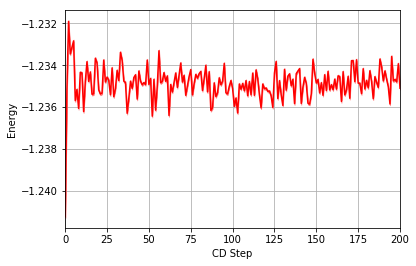

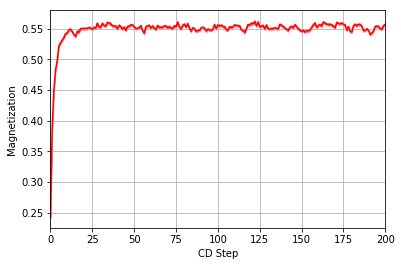

In [9]:
n_eq = 200
simulation = tfim.Run(nn_state,n_eq, show_convergence=True)

step = list(range(n_eq+1))

Energy     = simulation['energy']
err_energy = np.std(Energy)/np.sqrt(len(Energy))

sigmaZ = simulation['sigmaZ']
err_sZ = np.std(sigmaZ)/np.sqrt(len(sigmaZ))

plt.figure(1)
ax1 = plt.axes()
ax1.plot(step, Energy, color='red')
ax1.fill_between(step, Energy-err_energy, Energy+err_energy, color='red', alpha=0.4) 
#ax1.plot(step, true_energy, color='black')
ax1.grid()
ax1.set_xlim(0,n_eq)
ax1.set_xlabel('CD Step')
ax1.set_ylabel('Energy')

plt.figure(2)
ax2 = plt.axes()
ax2.plot(step, sigmaZ, color='red')
ax2.fill_between(step, sigmaZ-err_sZ, sigmaZ+err_sZ, color='red', alpha=0.4) 
#ax2.plot(step_list, true_mag, color='black')
ax2.grid()
ax2.set_xlim(0,n_eq)
ax2.set_xlabel('CD Step')
ax2.set_ylabel('Magnetization')

You can see a brief transient period in each observable, before the state of the machine "warms up" to equilibrium.  After that, the values fluctuate around the mean.  The exact value for the energy is -1.2785, and for the magnetization is 0.7072.